# Machine Learning Dynamical Systems

In [ ]:
### Install dependencies
!pip install numpy matplotlib scipy
!pip install tqdm plotly
!pip install torch torchvision torchaudio
!pip install optuna
!pip install pytorch-lightning
!pip install google
!pip install odeintw
!pip install torchdiffeq
!pip install sdeint
!pip install torchsde

In [1]:
#!/usr/bin/env python3
%matplotlib inline

# Basic import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from odeintw import odeintw
from sklearn.metrics import r2_score
import pandas as pd
import math
from scipy.linalg import qr
from scipy.stats import wasserstein_distance as wd


# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Trainig with lighninig
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping 
from pytorch_lightning import Callback


# Import Network models
from LSTM import LSTM
from FFNet import FFNet
from TRANSFORMER import Transformer
from CAE import ConvAE
from CLSTMAE import ConvLSTMAE
from CVAE import CVAE
from ADALSTM import multi_rate_sampler, pretrain, AdaLSTM
from pyESN import ESN
#from Informer.model import InformerStack


# import models
from models import Lorenz63, Roessler76, Lorenz96

# dq dimension
from DsTools import Box, DS, KL_div, wasserstein_distance


# Import plot functions
from plot import plot_trajectory, compare_trajectories, plot_3Dtrajectory, poincare_plot, plot_powspec, plot_rec_trajectory, plot_params_distr, plot_3ddistr
from plot import compare_R2scores, plot_compute_pdf

# Import dataset
from dataset import DynSysDataset, GenerateDynSystem

# Import callbacks
from callbacks import MetricsCallback

# Import utilities
from utils import Eul, RK4, CeDLoss, Sampler, nKLDivLoss, R2Score, ENLoss

# import k-fold cross validation routines
from kf_cv import kf_train_epochs, early_stopping

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
import plotly
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys

## Example of attractors

In [ ]:

v = 0.2
w = 1
def f_harm(u, t):
    return u[1], -v*u[1]-w**2*u[0]

def f_vp(u,t):
    return u[1], (v-u[0]**2)*u[1]-w**2*u[0]

u0 = [1,1]
time = np.linspace(0,100,1000)
us_harm = odeint(f_harm, u0, time)

u0 = [0.5,0.5]
us_vp = odeint(f_vp, u0, time)
u0 = [1,1]
us2 = odeint(f_vp, u0, time)

# Lorenz63
sigma=10
rho=28,
beta = 8./3.
def f_l63(u, t):
    return sigma*(u[1]-u[0]), u[0]*(rho-u[2])-u[1], u[0]*u[1]-beta*u[2]

u0 = [1,1,1]
time = np.linspace(0,40,4000)
ldyn = odeint(f_l63, u0, time)

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection="3d")
ax.plot(ldyn[1000:,0], ldyn[1000:,1], ldyn[1000:,2], c="black")
ax._axis3don = False
plt.show()
plt.tight_layout()
fig.savefig("images/l63_attractor.png")

# Roessler 76
a=0.37
b=0.2
c=5.7
def f_roess(u,t):
    return -u[1]-u[2], u[0]+a*u[1], b+u[2]*(u[0]-c)

u0 = [1,1,1]
time = np.linspace(0,100,10000)
ldyn = odeint(f_roess, u0, time)

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection="3d")
ax.plot(ldyn[1000:,0], ldyn[1000:,1], ldyn[1000:,2], c="black")
ax._axis3don = False
plt.show()
plt.tight_layout()
fig.savefig("images/roess_attractor.png")

a=1.4
b=0.3

he = [[-0.1,0.1]]
for i in range(100000):
    x = 1+he[-1][1]-a*he[-1][0]**2
    y = b*he[-1][0]
    he.append([x,y])
    
he = np.array(he)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(he[1000:,0], he[1000:,1], c="black", s=0.01)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# Inset axis
axins = ax.inset_axes([0.1, 0.3, 0.4, 0.4])
axins.set_xticks([])
axins.set_yticks([])
axins.set_xlim(0.7, 1)
axins.set_ylim(0.12, 0.18)
axins.scatter(he[1000:,0], he[1000:,1], c="black", s=0.01)
ax.indicate_inset_zoom(axins, edgecolor="black")
# Inset2
axins2 = axins.inset_axes([0.6, 0.6, 0.4, 0.4])
axins2.set_xticks([])
axins2.set_yticks([])
axins2.set_xlim(0.863, 0.9)
axins2.set_ylim(0.14, 0.15)
axins2.scatter(he[1000:,0], he[1000:,1], c="black", s=0.01)
axins.indicate_inset_zoom(axins2, edgecolor="black")

plt.show()
fig.savefig("images/henon_attractor.png")


In [ ]:
### Embeddings

In [ ]:
### Logistic map
lm = []
r_values = np.linspace(2.5,4,1000)
for r in r_values:
    lm_r = [0.3]
    for i in range(1000):
        x_new = r*lm_r[-1]*(1-lm_r[-1])
        lm_r.append(x_new)

    lm.append(lm_r)

lm = np.array(lm)
print(lm.shape, r_values.shape)

# Plot
fig, ax = plt.subplots(1,2,figsize=[10, 5])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$x_{\infty}$")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
for xe, ye in zip(r_values, lm[:,100:]):
    ax[0].scatter([xe] * len(ye), ye, s=0.001, c="black")

# Inset axis
axins = ax[0].inset_axes([1.2, 0,1,1])
axins.set_xticks([])
ax[1].set_yticks([])
axins.set_xlim(3.5, 4)
axins.set_ylim(0, 1)
for xe, ye in zip(r_values[667:], lm[667:,100:]):
    ax[1].scatter([xe] * len(ye), ye, s=0.001, c="black")
    
ax[0].indicate_inset_zoom(axins, edgecolor="black")
# Inset2
plt.savefig("images/bifurcation_logistic.png")

In [ ]:
# Feigenbaum attractor
mu = 3.57
lm_r = [0.3]
for i in range(101000):
    x_new = mu*lm_r[-1]*(1-lm_r[-1])
    lm_r.append(x_new)

lm_r = np.array(lm_r)

# Plot
fig, ax = plt.subplots(1,1,figsize=[10, 5])
ax.set_xlabel("$x_{\infty}$")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
discard=1000
ax.hist(lm_r[discard:], bins=1000, color="black", density=True, range=([0,1]))

# Inset2
plt.savefig("images/feigenbaum_attractor.png")

In [ ]:
print(lm.shape)

In [ ]:
### Pendolum
v = 0.22
T = 2.7

def f_pend(u,t):
    return T*np.sin(t)-np.sin(u[1])-v*u[0], u[0]

u0 = [0,0]
time = 1000000
dt = 0.01
time = np.linspace(0,time,int(time/dt))
n = int(2*math.pi/dt)
pend = odeint(f_pend, u0, time)
pend = np.array(pend)
pend[:,1] = pend[:,1]%(2*math.pi)-math.pi
pend = pend[0::n]
print(pend.shape)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(pend[:,1], pend[:,0], c="black", s=0.01)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylabel("$d\\theta/dt$")
ax.set_xlabel("$\\theta$")

plt.show()
fig.savefig("images/pendolum_attractor.png")


In [ ]:
def plot_2dPhaseDiagram(us, us2=None, filename=None):
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    arrow_fmt = dict(markersize=4, color='black', clip_on=False)
    arrow_2 = dict(markersize=12, color='black', clip_on=False)
    ax.plot(us[:-600,0], us[:-600,1],  c="black")
    ax.plot(us[-600:,0], us[-600:,1],  c="red")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.annotate("A", (us[0,0]+0.05, us[0,1]))
    ax.scatter(us[0,0], us[0,1], s=20,  c="black" )
    
    if us2 is not None:
        ax.scatter(us2[0,0], us2[0,1], s=20,  c="black" )
        ax.plot(us2[:-100,0], us2[:-100,1],  c="black")
        ax.annotate("B", (us2[0,0]+0.1, us2[0,1]))
        ax.plot(us2[-100:,0], us2[-100:,1],  c="red")
        
 
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('$x^{(1)}$', size=14, labelpad=-24, x=1.03)
    ax.set_ylabel('$x^{(2)}$', size=14, labelpad=-21, y=1.02, rotation=0)

    
    ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
    ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)
    
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    return fig

fig = plot_2dPhaseDiagram(us_harm, filename="images/phase_diagram_oscillator.png")
fig = plot_2dPhaseDiagram(us_vp, us2, filename="images/phase_diagram_vanderPol.png")


## Prepare data

### Parameters and systems

In [2]:
### Parameters
dt = 0.002
train_steps = int(200/dt) # 200 seconds
val_steps = int(20/dt) # 20 seconds
test_steps = int(200/dt) #100 seconds
kf_steps = int(10/dt) # 10 seconds
time_pred = 1 # inverse of first Lyapunov exponent usually
seq_len = int(time_pred/dt)+1 #because we get rid of one element during prediction, useful for convolutional nn and ff
print("Seq_len: ", seq_len)
feedforward_steps = 1
discard = int(10/dt) # first ten seconds
sigma = None # standard deviation of stochastic noise inside th system
measure_noise = 0 # standard deviation of measurment noise outside th esystem
sparsity = 0 # percentage of dataset set to zero
include_time = False


### Systems
## Lorenz63
true_params_l63 = np.array((28., 10., 8.0/3.0))
true_params_l63 = torch.tensor(true_params_l63, dtype=torch.float32, requires_grad=False)
l63 = Lorenz63(params=true_params_l63)
l63.params.requires_grad = False

## Lorenz96
n_dim = 5
np.random.seed(0)
true_params_l96 = np.array((np.ones(n_dim), np.random.uniform(0.9, 1.1, n_dim), np.random.uniform(7.9, 8.1, n_dim)))
true_params_l96 = torch.tensor(true_params_l96, dtype=torch.float32, requires_grad=False)
l96 = Lorenz96(dim=n_dim, params=true_params_l96)
l96.params.requires_grad = False


## Rössler
true_params_r76 = (0.37, 0.2, 5.7)
true_params_r76 = torch.tensor((0.37, 0.2, 5.7), dtype=torch.float32, requires_grad=False)
r76 = Roessler76(params = true_params_r76)
r76.params.requires_grad = False

# Define system to use and generate data
true_system = l63
true_params = true_params_l63
#true_system.args.requires_grad = False
#print(true_system.args)

Seq_len:  501


### Dataset and Dataloader

In [ ]:
torch.manual_seed(0)

# Train dataset
state0 = torch.rand(true_system.dim)
filename = "datasets/train_"+true_system.__class__.__name__+"_steps"+str(train_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
train_dataset, t_train = GenerateDynSystem(state0, true_system, dt, train_steps, discard, filename, sigma, measure_noise, sparsity, include_time)()

# Validtion dataset
state0 = torch.rand(true_system.dim)
filename = "datasets/val_"+true_system.__class__.__name__+"_steps"+str(val_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
val_dataset, t_val = GenerateDynSystem(state0, true_system, dt, val_steps, discard, filename, sigma, measure_noise, sparsity, include_time)()


# Test dataset
state0 = train_dataset[-1]
discard_test=0
filename = "datasets/test_"+true_system.__class__.__name__+"_steps"+str(test_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
test_dataset, t_test = GenerateDynSystem(state0, true_system, dt, test_steps, discard_test, filename, sigma, measure_noise, sparsity, include_time)()


# k-fold cross validation dataset
state0 = torch.rand(true_system.dim)
filename = "datasets/kf_"+true_system.__class__.__name__+"_steps"+str(kf_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
kf_dataset, t_kf = GenerateDynSystem(state0, true_system, dt, kf_steps, discard, filename, sigma, measure_noise, sparsity, include_time)()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100000 100000
Mean test dataset:  [ 0.6042473  0.5974225 23.516527 ]
Std test dataset:  [7.8889995 8.981161  8.647525 ]


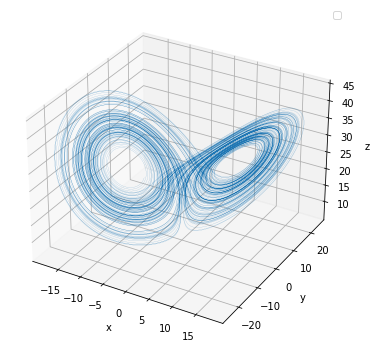

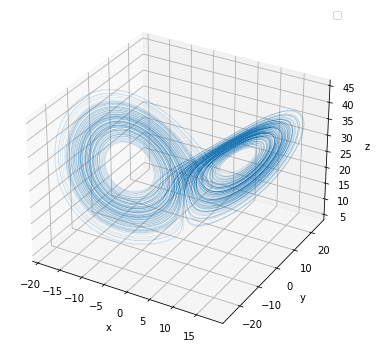

In [3]:
### Dataloaders
batch_size = 20
train_filename = "datasets/train_"+true_system.__class__.__name__+"_steps"+str(train_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"

# train dataset
train_states = DynSysDataset(train_filename, seq_len=seq_len, dt=dt, tau=1)
t_train = train_states.time
train_dataset = train_states.dataset
train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)

# validation dataset
val_filename ="datasets/val_"+true_system.__class__.__name__+"_steps"+str(val_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
val_states = DynSysDataset(train_filename, seq_len=seq_len, dt=dt, tau=1)
t_val = val_states.time
val_dataset = val_states.dataset
val_dataloader = DataLoader(val_states, batch_size=batch_size, num_workers=0, shuffle=False)

# test dataset
test_filename = "datasets/test_"+true_system.__class__.__name__+"_steps"+str(test_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
test_states = DynSysDataset(test_filename, seq_len=seq_len, dt=dt, tau=1)
t_test = test_states.time
test_dataset = test_states.dataset
test_dataloader = DataLoader(test_states, batch_size=batch_size, num_workers=0, shuffle=True)




### Plot dataset
# Train dataset
#rk4 = RK4(dt, true_system)
#eul = Eul(dt, true_system)
#train_dataset = eul(train_dataset)
name_dyn_data = "images/dynamics_"+true_system.__class__.__name__+".png"
name_train_attractor = "images/attractor_"+true_system.__class__.__name__+".png"
name_test_attractor = "images/attractor_test_"+true_system.__class__.__name__+".png"
#train_dynamics = plot_trajectory(train_dataset, time=t_train, n_var=3, labels=["x","y","z"], filename = name_dyn_data, prediction_steps=10000)
color_train = torch.rand_like(train_dataset)
color_test = torch.rand_like(test_dataset)
train_attractor = plot_3Dtrajectory(train_dataset, filename = name_train_attractor, color=None)
test_attractor = plot_3Dtrajectory(test_dataset, filename = name_test_attractor, color=None)
print(test_dataset.shape[0], t_test.shape[0])

# Statistics test dataset
mean_test_dataset = np.mean(test_dataset.detach().cpu().numpy(), axis=0)
std_test_dataset = np.std(test_dataset.detach().cpu().numpy(), axis=0)


print("Mean test dataset: ", mean_test_dataset)
print("Std test dataset: ", std_test_dataset)




In [ ]:
batch = next(iter(train_dataloader))
print(batch.shape)
batch_A = torch.flatten(batch[:,-1,:], start_dim=1)
print(batch_A.shape)

## LSTM

### Hyperparameter optimization

In [ ]:
### Hyperparameter optmization

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-1, log = True)
    tau = 1 # trial.suggest_int("tau", 1,5)
    batch_size = 20 # trial.suggest_int("batch_size", 10,50)
    seq_len = trial.suggest_int("seq_len", 100,1000)
    hidden_units = 100 #trial.suggest_int("hidden_units", 10,200)
    layers_num = 2 #trial.suggest_int("layers_num", 2,5)
    drop_p = 0.3 #trial.suggest_float("dropout", 0.0, 1.0)
    use_pi_loss = True
    int_mode = True

    # Define network
    model = LSTM(input_size=true_system.dim, hidden_units=hidden_units, layers_num=layers_num, system=true_system, 
              true_system=true_system,drop_p=drop_p, method_name="RK4", use_pi_loss=use_pi_loss, int_mode=int_mode,
             return_rnn=False, perturbation=None, bidirectional=False, train_out=True)

    # Define optimizer
    optimizer = model.configure_optimizers()
        
    max_num_epochs = 1000
    early_stopping = True
    k_fold = 3
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # kf dataset
    kf_filename = "datasets/kf_"+true_system.__class__.__name__+"_steps"+str(kf_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
    kf_states = DynSysDataset(kf_filename, seq_len=seq_len, dt=dt, tau=tau)
    es = early_stopping(10, mode="min")
    mean_train_loss, std_train_loss, mean_val_loss, std_val_loss = kf_train_epochs(model, device, k_fold, batch_size, kf_states, optimizer, max_num_epochs, early_stopping=es)

    
    # Metric to be minimized is the last validation loss
    return np.mean(mean_val_loss[-1])


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials= 10)

In [ ]:
study.best_params

### Learning the dynamics

In [4]:
# Define the callbacks
metrics_callback =  MetricsCallback()
#early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and define network
torch.manual_seed(0)

# Check batch dimension
use_pi_loss = False
int_mode = True # if True integrator, else derivator

# set type (always integrator for pi loss)
if use_pi_loss:
    type="pi"
else:
    if int_mode:
        type="ddint"
    else:
        type="dd"

hidden_units = 100
layers_num = 2
l1 = 0
weight_decay = 0
torch.manual_seed(0)
net = LSTM(input_size=true_system.dim, hidden_units=hidden_units, layers_num=layers_num, system=true_system, 
              true_system=true_system,drop_p=0.3, method_name="RK4", use_pi_loss=use_pi_loss, int_mode=int_mode,
             return_rnn=False, perturbation=None, bidirectional=False, train_out=True, l1=l1, weight_decay=weight_decay)



LSTM initialized


In [ ]:
# Define optimizer
optimizer = net.configure_optimizers()
        
max_num_epochs = 100
k_fold = 3
batch_size = 20 
kf_filename = "datasets/kf_"+true_system.__class__.__name__+"_steps"+str(kf_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)+".csv"
kf_states = DynSysDataset(kf_filename, seq_len=seq_len, dt=dt, tau=1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
es = early_stopping(patience=10, mode="min")
net.to(device)
mean_train_loss, std_train_loss, mean_val_loss, std_val_loss = kf_train_epochs(net, device, k_fold, batch_size, kf_states, optimizer, max_num_epochs, early_stopping=es)


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:353: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


In [ ]:
### Plot k-fold losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(mean_train_loss, c = "b", label='Train loss')
trained_epochs = len(mean_train_loss)
ax1.fill_between(np.array(range(trained_epochs)), np.subtract(mean_train_loss,std_train_loss), np.add(mean_train_loss,std_train_loss), color = "r")
#ax1.semilogy(mean_val_log, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Load from file
state_dict = torch.load("trained_models/"+"LSTM_dd_Lorenz63_ep2000_h100_ln2_sigmaNone.torch")
net.load_state_dict(state_dict)


In [ ]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
net.set_output(False)
trainer = pl.Trainer(max_epochs=1000, callbacks=[metrics_callback, early_stopping], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Names for savings
root = net.__class__.__name__+"_"+type+"_"+true_system.__class__.__name__+"_ep"+str(len(metrics_callback.train_loss_log))+"_h"+str(hidden_units)+"_ln"+str(layers_num)+"_sigma"+str(sigma)+"_l1"+str(l1)+"_noise"+str(measure_noise)+"_spars"+str(sparsity)
#root = "LSTM_pi_Lorenz63_ep2000_h100_ln2_sigmaNone"
name_net = root+".torch"
name_loss = "loss_"+root+".png"
name_compare = "compare_"+root+".png"
name_predict = "predict_"+root+".png"
delay = 1
name_poincare = "poincare_delay"+str(delay)+"_"+root+".png"
name_powspec = "powspec_"+root+".png"
name_le = "le_"+"root"+".png"
folder = "images/"


In [ ]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
ax.semilogy(metrics_callback.params_loss_log, label="Args loss")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
#fig.savefig(folder+name_loss)
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(net.state_dict(),"trained_models/"+name_net)

## Multi rate sampling

In [ ]:
### Multi rate sampler
num_lstm = 2
tau = np.arange(1,num_lstm+1)
length = [100]*num_lstm
batch_size = 20
mrs = multi_rate_sampler(tau, length, dt, batch_size=batch_size)

# Dataloaders
train_filename = "datasets/train_"+true_system.__class__.__name__+"_steps"+str(train_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+".csv"
train_mrs_list = mrs.divide_dataloader(train_filename, num_workers=0, shuffle=True)
val_filename = "datasets/val_"+true_system.__class__.__name__+"_steps"+str(val_steps)+"_dt"+str(dt)+"_sigma"+str(sigma)+".csv"
val_mrs_list = mrs.divide_dataloader(val_filename, num_workers=0, shuffle=False)


# Stack lstm
use_pi_loss = True
hidden_units = 100
layers_num = 2
stack_lstm = {}
torch.manual_seed(0)
for i in range(num_lstm):
    model = LSTM(input_size=true_system.dim, hidden_units=hidden_units, layers_num=layers_num, system=true_system, 
                 true_system=true_system, drop_p=0.3, method_name="RK4", use_pi_loss=use_pi_loss, return_rnn=False, perturbation=None, bidirectional=False, train_out=True)
    stack_lstm["LSTM"+str(i+1)] = model
    


In [ ]:
# Pretrain
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
train_loss_logs, val_loss_logs = pretrain(stack_lstm, train_mrs_list, val_mrs_list, patience=20, max_num_epochs=3)

In [ ]:
### Plot pretrain losses
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title("Training loss")
ax[0].set_xlabel("Epoch num")
ax[1].set_title("Validation loss")
ax[1].set_xlabel("Epoch num")

for i in range(num_lstm):
    ax[0].semilogy(train_loss_logs[i], label="LSTM "+str(i+1))
    ax[1].semilogy(val_loss_logs[i], label="LSTM "+str(i+1))
    
ax[0].legend()
ax[1].legend()
#fig.savefig(folder+name_pretrain_losses)

In [ ]:
# Save pretrain models 
torch.save(stack_lstm,"trained_models/pretrain.torch")

In [ ]:
# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Define adaptive LSTM
torch.manual_seed(0)
ada_lstm = AdaLSTM(stack_lstm, mrs, true_system.dim, hidden_units, lr=0.001, return_rnn=False)
print(ada_lstm)

In [ ]:
ada_lstm.state_dict()

In [ ]:
# Load from file
root = "AdaLSTM_pi__numlstm5_Lorenz63_ep296_h100_ln2_sigmaNone"
name_net = root+".torch"
state_dict = torch.load("trained_models/"+name_net)
ada_lstm.load_state_dict(state_dict)

In [ ]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
trainer = pl.Trainer(max_epochs=1000, callbacks=[metrics_callback, early_stopping], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=ada_lstm, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
### Names for savings
if use_pi_loss:
    type="pi"
else:
    type="dd"
    
#root = ada_lstm.__class__.__name__+"_"+type+"_"+"_numlstm"+str(num_lstm)+"_"+true_system.__class__.__name__+"_ep"+str(len(metrics_callback.train_loss_log))+"_h"+str(hidden_units)+"_ln"+str(layers_num)+"_sigma"+str(sigma)
#root = "AdaLSTM_numlstm3_Lorenz63_ep148_h100_ln2_sigmaNone"
name_net = root+".torch"
name_loss = "loss_"+root+".png"
name_pretrain_losses = "pretrain_loss_"+root+".png"
name_compare = "compare_"+root+".png"
name_predict = "predict_"+root+".png"
name_poincare = "poincare_"+root+".png"
name_powspec = "powspec_"+root+".png"
name_le = "le_"+"root"+".png"
folder = "images/"


In [ ]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
#fig.savefig(folder+name_loss)
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
### Generate trajectory
def gen_mrs_trajectory(net, x0, num_lstm, prediction_steps = 1000):
    " Generate a trajectory of prediction_steps lenght starting from test_dataset[0]. Return np.array"
    x = [x0.unsqueeze(0).unsqueeze(0)]*num_lstm
    rnn_state = [(torch.zeros(net.layers_num_list[i], 1, net.hidden_units), torch.zeros(net.layers_num_list[i], 1, net.hidden_units)) for i in range(num_lstm)]
    print(rnn_state[0][1].shape)
    print(x[0].shape)
    net_states = []
    net.eval()
   
    for i in range(prediction_steps):
        with torch.no_grad():
            # Forward past
            x, rnn_state = net(i, x, rnn_state)
            net_states.append(x.squeeze().numpy())
            x = [x.unsqueeze(1)]*num_lstm

    return torch.tensor(net_states)


ada_lstm.set_return_rnn(True)
net_states = gen_mrs_trajectory(ada_lstm.cpu(), test_dataset[0], num_lstm, prediction_steps=20000)

 

In [ ]:
print(net_states.shape)

In [ ]:
plt.plot(ada_lstm.attention.data.detach().cpu().numpy())
print(ada_lstm.attention.data.detach().cpu().numpy())


In [ ]:
### Plot trajectories
# Compare trajectory
compare = compare_trajectories(net_states, test_dataset, time=t_val, n_var=3, filename=None, prediction_steps=2000)
# Attractor
plot_3Dtrajectory(net_states, filename=None, color=None)
print(net_states[1:, 0].size, net_states[:-1,0].size)
# Poincare map
poincare_plot(net_states, torch.tensor(test_dataset), filename=None, prediction_steps=10000)
# Power spectrum
plot_powspec(net_states, test_dataset, filename=None)


In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(ada_lstm.state_dict(),"trained_models/"+name_net)

### Autograd time differantiation

In [ ]:
# Train dataset
state0 = [1.0, 1.0, 1.0]
include_time = True
train_states = DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
t_train = train_states.time
train_dataset = train_states.dataset
train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)

In [ ]:
# Define network
max_num_epochs = 2000
c = 0.01
d = 0.5

loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0), include_time=include_time)

input_size = 4 if include_time else 3
params = {
    "input_size" : 4,
    "hidden_units" : 100,
    "layers_num" : 2,
    "drop_p" : 0.3,
    "loss_fn" : loss_fn,
    "lr" : 0.01,
    "feedforward_steps" : 1,
    "curriculum_learning" : None,
}

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and define network
torch.manual_seed(0)
net_pi = LSTM(params)

In [ ]:
### Trye torch.autograd
batch = next(iter(train_dataloader))
net_pi.set_output(False)
out = net_pi(batch)
# Reshape
batch = torch.reshape(batch[0,:100], (100,4))
out = torch.reshape(out[0,:100], (100,4))

grad_outputs = torch.tensor([[0.,0.,0.,1.]]*100)
print(grad_outputs.shape)

grad = torch.autograd.grad(out[0], batch[0], grad_outputs=grad_outputs[0], is_grads_batched=False)
print(grad)


## Attention

### Transformer

In [ ]:
# parameters
d_model = 3
nhead = 3
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 360
dropout = 0.3
l1 = 0
use_pi_loss = True
apply_src_mask = False
apply_tgt_mask = True


# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and network
torch.manual_seed(0)
net_tf = Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, system=true_system, 
                     true_system=true_system, dropout=dropout, 
                     activation="ReLU", lr=0.001, l1=l1, dt=dt, method_name="RK4", use_pi_loss=use_pi_loss, 
                     apply_src_mask=apply_src_mask, apply_tgt_mask=apply_tgt_mask)


In [ ]:
### Trainig
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=1000, callbacks=[metrics_callback, early_stopping], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_tf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_transformer.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"trained_models/Transformer")


### Informer


In [ ]:
# Define loss functions
loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0))

# Define the network
torch.manual_seed(0)
net_inf = InformerStack(enc_in = 3, dec_in = 3, c_out = 3, seq_len = 499, label_len = 499, out_len = 1, 
                factor=5, d_model=512, n_heads=8, e_layers=[3,2,1], d_layers=2, d_ff=512, 
                dropout=0.3, lr=0.001, loss_fn=loss_fn, attn='prob', embed='fixed', freq='h', activation='gelu')

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

In [ ]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=100, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_inf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)



In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_informer.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"trained_models/Informer")

## Convolutional Neural Networks

In [ ]:
### Define loss function
loss_fn = nn.MSELoss() 
max_num_epochs = 1000

### Define network
torch.manual_seed(0)
net_ae = ConvEncoder(in_channels=(1,16), out_channels=(16,32), kernel_sizes=((100,3), (100,1)), 
           padding=(0,0),  encoded_space_dim=2, act=nn.ReLU, drop_p=0.3, seq_len=seq_len,
                loss_fn=loss_fn, lr=0.001)

### Define callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 1000, mode="min")

In [ ]:
### Set proper device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Training
trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_tf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_autoencoder.png")

In [ ]:
### Plot reconstructed trajectory
enc, rec = net_ae(val_states.data)
rec = rec.detach().numpy()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")
for i in range(len(rec)):
    ax.plot(rec[i,0,:,0], rec[i,0,:,1], rec[i,0,:,2], c="b")

## Autoencoders

### Convolutional Autoencoder

In [ ]:
### Define network
torch.manual_seed(0)
encoded_space_dim = 20
enc_space_reg = None
beta = 1.0
gamma = 1
lr = 0.001
lr_scheduler_name = "ExponentialLR" 

net_ae = ConvAE(in_channels=(1,16,16), out_channels=(16,16,32), kernel_sizes=((5,3), (5,1), (5,1)), 
           padding=(0,0,0),  encoded_space_dim=encoded_space_dim, act=nn.ReLU, drop_p=0.3, seq_len=seq_len, feedforward_steps=1,
                lr=lr, dt=dt, system_name="Lorenz63",system_dim=3,num_param=len(true_params), enc_space_reg=enc_space_reg,
                beta=beta, lr_scheduler_name=lr_scheduler_name, gamma=gamma)

### Define callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")



In [ ]:
# Load from file
state_dict = torch.load("trained_models/"+name_net)
net_ae.load_state_dict(state_dict)

In [ ]:
### Set proper device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Training
trainer = pl.Trainer(max_epochs=1000, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_ae, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Define saving names
if enc_space_reg is not None:
    type="reg"
else:
    type="unreg"
    
root = net_ae.__class__.__name__+"_"+type+"_"+true_system.__class__.__name__+"_"+str(len(metrics_callback.train_loss_log))+"_es"+str(encoded_space_dim)+"_sigma"+str(sigma)+"_"+lr_scheduler_name+str(gamma)
root = "ConvAE_reg_Lorenz63_1500_es10_sigmaNone"
name_net = root+".torch"
name_loss = "loss_"+root+".png"
name_rec = "rec_"+root+".png"
name_predict = "predict_"+root+".png"
name_poincare = "poincare_"+root+".png"
name_powspec = "powspec_"+root+".png"
name_hist = "hist_"+root+".png"
name_distr = "distr_"+root+".png"

folder = "images/"

In [ ]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
if enc_space_reg is not None:
    ax.semilogy(metrics_callback.train_reg_log, label="Train reg loss")
    ax.semilogy(metrics_callback.val_reg_log, label="Validation reg loss")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
#fig.savefig("images/"+name_loss)
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
# predict
net_states = net_ae.predict(time=200, inputs=test_dataset.to(device), input_is_looped=False)
print(net_states.shape)

In [ ]:
### Plot trajectories
# Compare trajectory
delay=50
compare = compare_trajectories(net_states, test_dataset, time=t_test, n_var=3, filename=None, prediction_steps=5000)
# Attractor
plot_3Dtrajectory(net_states, filename=None, color=None)
print(net_states[1:, 0].size, net_states[:-1,0].size)
# Poincare map
poincare_plot(net_states, true_states=torch.tensor(test_dataset), delay=delay, filename=None, prediction_steps=5000)
# Power spectrum
plot_powspec(net_states, test_dataset, filename=None)

In [ ]:
# r2 scores
r2_scores = compare_R2scores(net_ae, test_dataset, time=1.002)
mean = np.mean(r2_scores, axis=0)
std = np.std(r2_scores, axis=0)
print("Mean: ", mean)
print("Std: ", std)

In [ ]:
### Plot reconstructed traejctory
net_ae.eval()
enc, rec = net_ae(0, test_states.data.unsqueeze(1))
print(enc.shape)

plot_rec_trajectory(rec, filename=None)
# Plot learned parameters distribution
fig1, statistics= plot_params_distr(enc[:, 0:3], true_params=true_params, bins=20, filename=None)
print(statistics)
fig2 = plot_3ddistr(enc, true_params, indeces=[0,1,2],filename=None)

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(net_ae.state_dict(),"trained_models/"+name_net)

### Convolutional LSTM autoencoder

In [ ]:
### Define network
torch.manual_seed(0)
encoded_space_dim = 10
enc_space_reg = "PI" # method to compute derivative, if None no regularization applied
bd = True # bidirectionality
lstm_hu = 100 # hidden units of lstm layers
ln = 2 # number of layers of lstm
beta= 1.0
gamma = 0.99
lr = 0.01
lr_scheduler_name = "ExponentialLR" 

net_lstmae = ConvLSTMAE(in_channels=(1,16,16), out_channels=(16,16,32), kernel_sizes=((5,3), (5,1), (5,1)), 
           padding=(0,0,0),  encoded_space_dim=encoded_space_dim, lstm_hidden_units=lstm_hu, bidirectional=bd, layers_num=ln, act=nn.ReLU, drop_p=0.3, seq_len=seq_len, feedforward_steps=1,
                lr=lr, dt=dt, system_name="Lorenz63",system_dim=3,num_param=len(true_params), enc_space_reg=enc_space_reg,
                       beta=beta, lr_scheduler_name=lr_scheduler_name, gamma=gamma)

### Define callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 20, mode="min")



In [ ]:
# Load from file
state_dict = torch.load("trained_models/"+"ConvLSTMAE_reg_Lorenz63_2500_es10_hu100_nl2_sigmaNone.torch")
net_lstmae.load_state_dict(state_dict)

In [ ]:
### Set proper device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Training
trainer = pl.Trainer(max_epochs=1000, callbacks=[metrics_callback, early_stopping], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_lstmae, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Define saving names
if enc_space_reg is not None:
    type="reg"
else:
    type="unreg"
    
    
root = net_lstmae.__class__.__name__+"_"+type+"_"+true_system.__class__.__name__+"_"+str(len(metrics_callback.train_loss_log))+"_es"+str(encoded_space_dim)+"_hu"+str(lstm_hu)+"_nl"+str(ln)+"_sigma"+str(sigma)+"_"+lr_scheduler_name+str(gamma)+"_beta"+str(beta)
#root = "ConvLSTMAE_reg_Lorenz63_2500_es10_hu100_nl2_sigmaNone"
name_net = root+".torch"
name_loss = "loss_"+root+".png"
name_rec = "rec_"+root+".png"
name_predict = "predict_"+root+".png"
name_poincare = "poincare_"+root+".png"
name_powspec = "powspec_"+root+".png"
name_hist = "hist_"+root+".png"
name_distr = "distr_"+root+".png"

folder = "images/"

In [ ]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
if enc_space_reg is not None:
    ax.semilogy(metrics_callback.train_reg_log, label="Train reg loss")
    ax.semilogy(metrics_callback.val_reg_log, label="Validation reg loss")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig("images/"+name_loss)
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
### Plot reconstructed traejctory
net_lstmae.eval()
enc, rec = net_lstmae(test_states.data)
print(enc.shape)
print(rec.shape)
plot_rec_trajectory(rec, filename="images/"+name_rec)
# Plot learned parameters distribution
fig1, statistics= plot_params_distr(enc, true_params, bins=20, filename="images/"+name_hist)
print(statistics)
fig2 = plot_3ddistr(enc, true_params, indeces=[0,1,2],filename="images/"+name_distr)

In [ ]:
### Generate trajectory
net_lstmae.eval()
epsilon = 1
new_enc = enc.unsqueeze(1).repeat(1,101,1) 
noise = torch.randn_like(new_enc)*epsilon
perturbed = new_enc + noise
perturbed = torch.tensor([0,0,0,0,0,0,0,0,0,0], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(990,101,1)
perturbed, rnn = net_lstmae.lstm(perturbed)
perturbed = net_lstmae.out(perturbed)

plot_rec_trajectory(perturbed.unsqueeze(1))
print(perturbed.shape)

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(net_lstmae.state_dict(),"trained_models/"+name_net)

### Convolutional Variational Autoencoder

In [ ]:
### Define network
torch.manual_seed(0)
encoded_space_dim = 10
enc_space_reg = "PI"
beta = 1.
net_vae = CVAE(in_channels=(1,16,16), out_channels=(16,16,32), kernel_sizes=((5,3), (5,1), (5,1)), 
           padding=(0,0,0),  encoded_space_dim=encoded_space_dim, act=nn.ReLU, drop_p=0.3, seq_len=seq_len, feedforward_steps=1,
                lr=0.001, dt=0.01, system_name="Lorenz63",system_dim=3,num_param=len(true_params), enc_space_reg=enc_space_reg,
                beta=beta)

### Define callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 1000, mode="min")



In [ ]:
# Load from file
state_dict = torch.load("trained_models/"+"CVAE_reg_Lorenz63_1000_es10_sigma5.0.torch")
net_vae.load_state_dict(state_dict)

In [ ]:
### Set proper device 
batch = next(iter(train_dataloader))
print(batch.shape)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Training
trainer = pl.Trainer(max_epochs=1000, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_vae, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Define saving names
if enc_space_reg is not None:
    type="reg"
else:
    type="unreg"
    
root = net_vae.__class__.__name__+"_"+type+"_"+true_system.__class__.__name__+"_"+str(len(metrics_callback.train_loss_log))+"_es"+str(encoded_space_dim)+"_sigma"+str(sigma)
#root = "CVAE_reg_Lorenz63_1000_es10_sigma5.0"
name_net = root+".torch"
name_loss = "loss_"+root+".png"
name_rec = "rec_"+root+".png"
name_predict = "predict_"+root+".png"
name_poincare = "poincare_"+root+".png"
name_powspec = "powspec_"+root+".png"
name_hist = "hist_"+root+".png"
name_noise = "noise_"+root+".png"
name_distr = "distr_"+root+".png"


folder = "images/"

In [ ]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
if enc_space_reg is not None:
    ax.semilogy(metrics_callback.train_reg_log, label="Train reg loss")
    ax.semilogy(metrics_callback.val_reg_log, label="Validation reg loss")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig("images/"+name_loss)
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
### Plot reconstructed traejctory
net_vae.eval()
enc, mean, logvar, indeces_1, indeces_2, indeces_3 = net_vae.encoder(test_states.data)
noise = Sampler()(mean, logvar)
rec = net_vae.decoder(enc, noise, indeces_1, indeces_2, indeces_3)
print(enc.shape)
print(mean.shape, logvar.shape)
#print(noise)
plot_rec_trajectory(rec, filename="images/"+name_rec)
# Plot learned parameters distribution
fig1, statistics= plot_params_distr(enc, true_params, bins=20, filename="images/"+name_hist)
fig2, statistics_noise= plot_params_distr(torch.cat((mean, logvar), dim=-1), torch.tensor((0,0), dtype=torch.float32, requires_grad=False), bins=20, filename="images/"+name_noise)
print(statistics)
fig3 = plot_3ddistr(enc, true_params, indeces=[0,1,2],filename="images/"+name_distr)

In [ ]:
### Generate trajectory


In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(net_vae.state_dict(),"trained_models/"+name_net)

### Reservoir Networks

In [ ]:
### Reservoir network
np.random.seed(0)
n_reservoir = 200
sparsity = 0.0
erdos_graph = False
use_pi_loss = True
spectral_radius = 1.2
noise = 0.1
net = ESN(n_inputs = 3, system=true_system, n_outputs = 3, sparsity=sparsity, erdos_graph=erdos_graph, n_reservoir=n_reservoir, 
              timestep=dt, spectral_radius=spectral_radius, noise=noise, extended_states=True, use_pi_loss=use_pi_loss)

# Training
pred, training_rmse, transient = net.fit(train_dataset[:-1,:].detach().numpy(), train_dataset[1:,:].detach().numpy())

### Names for savings
if use_pi_loss:
    type="pi"
else:
    type="ddint"


In [ ]:

root = net_esn.__class__.__name__+"_"+type+"_"+true_system.__class__.__name__+"_rnodes"+str(n_reservoir)+"_eg"+str(erdos_graph)+"_spars"+str(sparsity)+"_sr"+str(spectral_radius)+"_noise"+str(noise)+"_sigma"+str(sigma)
name_net = root+".torch"
name_loss = "loss_"+root+".png"
name_compare = "compare_"+root+".png"
name_predict = "predict_"+root+".png"
delay = 50
name_poincare = "poincare_delay"+str(delay)+"_"+root+".png"
name_powspec = "powspec_"+root+".png"
name_le = "le_"+"root"+".png"
folder = "images/"

## FeedForward network

In [ ]:
# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 20, mode="min")

# Define network
n_inputs = true_system.dim
n_outputs = true_system.dim
num_h_layers = 1
neurons = 128
hidden_layers = [neurons]*num_h_layers
drop_p = 0.1
use_pi_loss = False
int_mode = False

# set type (always integrator for pi loss)
if use_pi_loss:
    type="pi"
else:
    if int_mode:
        type="ddint"
    else:
        type="dd"
        
l1 = 0
weight_decay = 0
torch.manual_seed(0)
net = FFNet(seq_len, n_inputs, n_outputs, hidden_layers, system=true_system, true_system=true_system, drop_p=drop_p, lr=0.001, dt=dt, 
          method_name="RK4", activation="ReLU", use_pi_loss=use_pi_loss, int_mode=int_mode, l1=l1, weight_decay=weight_decay)


In [ ]:
# Load from file
state_dict = torch.load("trained_models/"+name_net)
net.load_state_dict(state_dict)

In [ ]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
trainer = pl.Trainer(max_epochs=1000, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
### Names for savings

root = net.__class__.__name__+"_"+type+"_"+true_system.__class__.__name__+"_ep"+str(len(metrics_callback.train_loss_log))+"_h"+str(num_h_layers)+"_ns"+str(neurons)+"_sigma"+str(sigma)
#root = "FFNet_pi_Lorenz63_ep21_h3_ns100_sigmaNone"
name_net = root+".torch"
name_loss = "loss_"+root+".png"
name_compare = "compare_"+root+".png"
name_predict = "predict_"+root+".png"
delay = 50
name_poincare = "poincare_delay"+str(delay)+"_"+root+".png"
name_powspec = "powspec_"+root+".png"
name_le = "le_"+"root"+".png"
folder = "images/"

In [ ]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
#ax.semilogy(metrics_callback.params_loss_log, label="Args loss")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
#fig.savefig(folder+name_loss)
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(net.state_dict(),"trained_models/"+name_net)

## Analysis

In [ ]:
# Predict (create dynamics)
net_states = net.predict(200, test_dataset, input_is_looped=True)
print(net_states.shape)

### Statistics (long term evaluation)

In [ ]:
# kl divergence
kl_div, _, _ = KL_div(net_states.detach().cpu().numpy(), test_dataset.detach().cpu().numpy(), epsilon=1.)
print(kl_div)

In [ ]:
### Statistics
mean_nn = np.mean(net_states.detach().cpu().numpy(), axis=0)
std_nn = np.std(net_states.detach().cpu().numpy(), axis=0)
print("NN statistics: ", mean_nn, std_nn)
print("Test dataset statistics: ", mean_test_dataset, std_test_dataset)
# Wasserstein distance
my_wass_dist = []
scipy_wass_dist = []
for i in range(true_system.dim):
    my_ws = wasserstein_distance(np.expand_dims(test_dataset.detach().numpy()[:,i],1), np.expand_dims(net_states.detach().cpu().numpy()[:,i],1), epsilon=1)
    scipy_ws = wd(test_dataset.detach().cpu().numpy()[:,i], net_states.detach().cpu().numpy()[:,i])
    my_wass_dist.append(my_ws)
    scipy_wass_dist.append(scipy_ws)
    
print("Wasserstein distances (mine): ", my_wass_dist)
print("Wasserstein distances (scipy): ", scipy_wass_dist)

# Marginal invariant measures
fig = plot_compute_pdf(net_states.detach().numpy(), epsilon=0.5, filename=None)

### R2 scores (short term evaluation)

In [ ]:
# r2 scores
time = 0.1
# net.set_output(True) # LSTM
r2_scores = compare_R2scores(net, test_dataset, time=time)
mean = np.mean(r2_scores, axis=0)
std = np.std(r2_scores, axis=0)
print("Mean: ", mean)
print("Std: ", std)

In [ ]:
# Plot histograms and colored attractor
fig, statistics = plot_params_distr(torch.tensor(r2_scores), plot_stat=False, true_params=None, labels=None, bins=100, filename=None)
r2_scores_mean_a1 = plot_3Dtrajectory(test_dataset[:-seq_len], color=r2_scores[:,0])
r2_scores_mean_a2 = plot_3Dtrajectory(test_dataset[:-seq_len], color=r2_scores[:,0])
r2_scores_mean_a3 = plot_3Dtrajectory(test_dataset[:-seq_len], color=r2_scores[:,0])


### Comparison trajectories

In [ ]:
### Plot trajectories
# Compare trajectory
delay=50
compare = compare_trajectories(net_states, test_dataset, time=t_test, n_var=3, filename=None, prediction_steps=4000)
# Attractor
plot_3Dtrajectory(net_states, filename=None, color=None)
print(net_states[1:, 0].size, net_states[:-1,0].size)
# Poincare map
poincare_plot(net_states, true_states=torch.tensor(test_dataset), delay=delay, filename=None, prediction_steps=5000)
# Power spectrum
plot_powspec(net_states, test_dataset, filename=None)

### Lyapunov analysis

In [ ]:
# DS module
ds = DS(test_dataset.detach().cpu().numpy(), eta=0.)

In [ ]:
# Lyapunov exponents analysis
discard = 150
n_div = 4
lles = ds.compute_lle(true_system, n_div, dt, discard)
print(lles.shape)
print("Lyapunov exponents (mean, std): ", ds.le, ds.le_std)

# lyapunov dimension
lyap_d = ds.lyap_d()
print("Lyapunov dimension: ", lyap_d)

# Distributions
fig, _ = plot_params_distr(torch.tensor(lles), plot_stat=True, true_params=[0.905, 0,-14.5714],
                           labels=["LLE1", "LLE2", "LLE3"], bins=200, filename=None)

lle1_attractor = plot_3Dtrajectory(test_dataset[0::n_div,:][discard:], color=lles[:,0])
lle2_attractor = plot_3Dtrajectory(test_dataset[0::n_div,:][discard:], color=lles[:,1])
lle3_attractor = plot_3Dtrajectory(test_dataset[0::n_div,:][discard:], color=lles[:,2])

In [ ]:
# d_q dimension
q=1
d_q = ds.d_q(q=q, min_eps=1, max_eps=1.2, num_eps=10, plot=True)
print("D_"+str(q)+" dimension: ", d_q)

In [ ]:
import matplotlib.cm as cm 


def plot_pdf(box, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(box.int_sizes[0]):
        for j in range(box.int_sizes[1]):
            for k in range(box.int_sizes[2]):
                indexes = [i,j,k]
                center = box.get_center_cube(indexes)
                ax.scatter(center[0], center[1], center[2], marker="s", s=200, c=cm.Reds(box.pdf[i,j,k]))
                print(cm.Reds(box.pdf[i,j,k]))
plot_pdf(box)

## Unsupervised lle computation (sperimental)

In [ ]:
#### Dataset generation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

eps = 0.01 # Perturbation
len_seq = 5 # Length of the pertubed sequence
t = np.arange(0.0, dt*len_seq, dt) # Time array

# Add pertubation dimension and dynamics dimension
print(states_dataset.shape) 
pd = np.expand_dims(states_dataset, axis=1)
pd = np.expand_dims(pd, axis=1)
perturbed_dataset = np.concatenate((pd, pd), axis=2)
perturbed_dataset = np.concatenate((perturbed_dataset, pd), axis=2)
print(perturbed_dataset.shape)


# Add perturbation
for i in range(3):
    perturbed_dataset[:,:,i,i] += eps
    
print(perturbed_dataset[0,:,0,:])

le_dataset = []
# Run the dynamics for all perturbations for len_seq steps
for state in perturbed_dataset:
    ev_dyn0 = np.expand_dims(odeint(f, state[0,0,:], t), axis=1)
    ev_dyn1 = np.expand_dims(odeint(f, state[0,1,:], t), axis=1)
    ev_dyn2 = np.expand_dims(odeint(f, state[0,2,:], t), axis=1)
   
    ev_dyn = np.concatenate((ev_dyn0, ev_dyn1), axis=1)
    ev_dyn = np.concatenate((ev_dyn, ev_dyn2), axis=1)
    le_dataset.append(ev_dyn)

# Convert to numpy
le_dataset = np.array(le_dataset)

In [ ]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

le_dataset = torch.tensor(le_dataset, requires_grad=True,dtype=torch.float)


### Dataloader
le_dataloader = DataLoader(le_dataset, batch_size=16, shuffle=True)
print(next(iter(le_dataloader)).shape)

### Training

In [ ]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_le = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in le_dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)


# Now output in function of the time and initial condition